# Simulations notebook

## Simulated data

### Poisson-logNormal $Z_i \sim N(\mu_i, \sigma_i^2)$

Set our latent $Z_i, i=1, \dots, 9$ with $Z_i \sim N(\mu_i, \sigma_i^2)$.

In [303]:
conda install -c conda-forge scanpy python-igraph leidenalg


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import scanpy as sc

In [ ]:
print(np.__version__)

In [ ]:
K = 20
n = 20000 # number of cells
N = G = 1000 # number of genes
np.random.seed(123)
mu = np.random.uniform(0,1, K)
Z = np.random.normal(mu,0.1) 

Linear model for each cell $i$, $ X_i = BZ_i + \epsilon$ 
ie for $K$ "modules" $Z_1,\dots, Z_K$ 

$X_{i} = \sum_k B_{ik}Z_k + \epsilon_i$, $\epsilon_i \sim N(0, \sigma_0^2 I_{G})$

Non linear transformation for count data: poisson lognormal $X_i \sim \mathcal{P}(e^{BZ_i+\epsilon})$

Here $N = G = 1000$

In [72]:
N = 1000
p = 0.3
def randbin(m, n, p, seed=123):  
    np.random.seed(seed)
    return np.random.choice([0, 1], size=(m,n), p=[p, 1-p])

def non_linear_transform(X, f=None):
    if f == 'exp':
        return np.exp(-X)
    if f == 'tanh':
        return np.tanh(X)
    if f == 'roll':
        return X*np.cos(X)
    else:
        return np.cos(X)
f = 'roll'
B = np.transpose(randbin(K,N, p))
sigma0 = np.var(non_linear_transform(B@Z, f=f))*0.3
eps = np.random.normal(0,sigma0, size=N)
X_nl = non_linear_transform(B@Z, f=f)

In [73]:
def poisson_lognormal(Z, seed=None):
    if seed!=None:
        np.random.seed(seed)
    sigma0 = np.sqrt(np.var(Z))*0.3
    eps = np.random.normal(0,sigma0, size=Z.shape[0])
    lam = np.exp(Z+eps)
    return np.random.poisson(lam)

X = np.array([poisson_lognormal(X_nl) for i in range(n)])

In [74]:
import umap
from sklearn.preprocessing import StandardScaler

In [75]:
reducer = umap.UMAP()
scaled_X = StandardScaler().fit_transform(X)
embedding = reducer.fit_transform(scaled_X)
embedding.shape

(20000, 2)

In [76]:
B.shape

(1000, 20)

In [77]:
keys = ['module_{}'.format(i) for i in range(K)]
B_dict = dict(zip(keys, B.T))

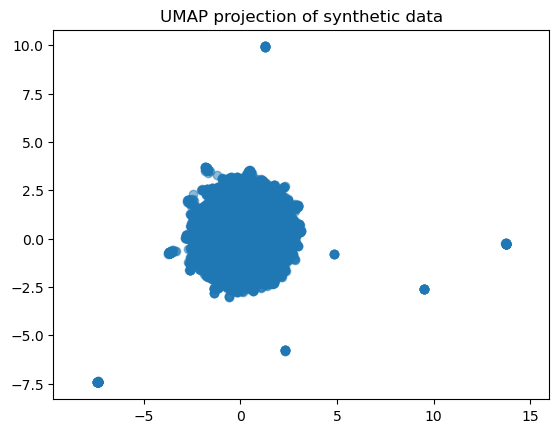

In [78]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.5
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of synthetic data', fontsize=12);

#### add interventions

Add interventions vector $d \in \mathbb{R}^G$, in a linear model $X_i(d) = \text{Poisson-lognormal}((B \otimes d) Z_i + \epsilon_i)$ where $d$ such that $d_k = 0$ for blocked genes, $d_k = 1$ for not blocked. 

Recall $B \in \mathbb{R}^{N\times K}$ with $N$ genes and $K$ modules. So intervention blocking gene $g$ should set row $g$ to zero in $B$ ($0_{1 \times K}$ vector).

In [154]:
X_d[:,1],X_d[:,3], X_d[:,20], X_d[:,15]

(array([2, 0, 1, ..., 3, 1, 2]),
 array([1, 0, 0, ..., 1, 0, 1]),
 array([2, 1, 0, ..., 1, 1, 0]),
 array([1, 1, 2, ..., 1, 1, 2]))

In [157]:
np.max(X), np.min(X), np.mean(X)

(56185, 0, 308.05642135)

<Axes: >

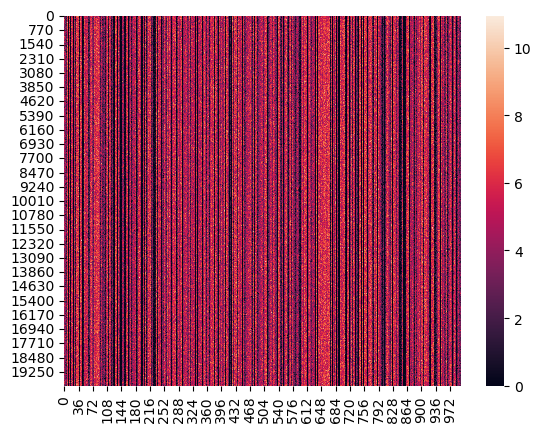

In [158]:
sns.heatmap(np.log(1+X))

<Axes: >

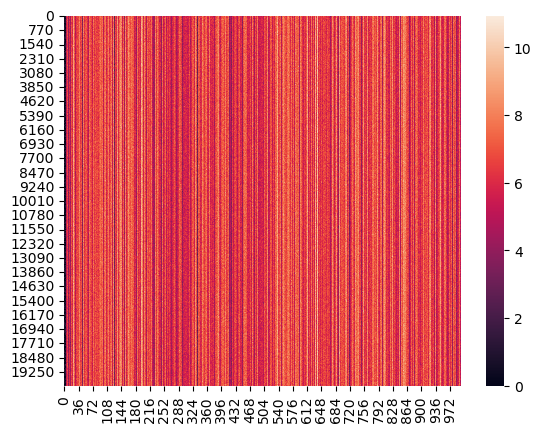

In [159]:
sns.heatmap(np.log(1+X_d))

Define knocked out genes.

In [88]:
d=np.ones(N)
d[20] = d[10] = d[3] =d[1]= d[15]= 0 # set genes 3, 10 and 100 as knock out. 
B_d = np.multiply(B.T,d).T

In [137]:
(B_d@Z).shape

(1000,)

In [100]:
X_d = np.array([poisson_lognormal(B_d@Z) for i in range(n)])

In [101]:
reducer = umap.UMAP()
scaled_X_d = StandardScaler().fit_transform(X_d)
embedding_d = reducer.fit_transform(scaled_X_d)
embedding_d.shape

(20000, 2)

<Axes: title={'center': 'X with knocked out genes'}>

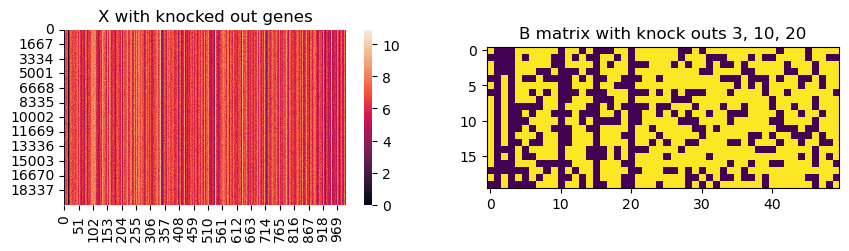

In [160]:
plt.figure(figsize=(10,5))
plt.subplot(222).set_title('B matrix with knock outs 3, 10, 20')
plt.imshow(B_d[:50,:].T)
plt.subplot(221).set_title('X with knocked out genes')
sns.heatmap(np.log(1+X_d))

#plt.scatter((B@Z)[:,0],(B@Z)[:,1], color='orange', alpha=1, label='all observed')
#plt.scatter((B_d@Z)[:,0],(B_d@Z)[:,1], color='blue', alpha=0.2, label='with knock outs')


In [179]:
X[:,3],X_d[:,3]

(array([ 20, 105,  71, ...,  32, 101,   9]), array([1, 0, 0, ..., 1, 0, 1]))

Text(0.5, 1.0, 'observation space between two genes for unperturbed versus with knock outs')

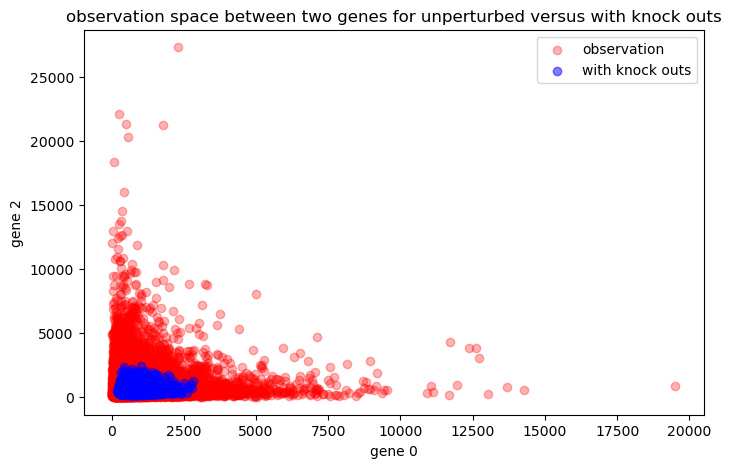

In [166]:
g1 = 0
g2 = 2
plt.figure(figsize=(8,5))
plt.scatter(X[:,g1],X[:,g2], color='red', alpha=0.3, label='observation baseline')
plt.scatter(X_d[:,g1],X_d[:,g2], color='blue', alpha=0.5, label='with knock outs')
plt.xlabel('gene {}'.format(g1))
plt.ylabel('gene {}'.format(g2))
plt.legend()
plt.title('observation space between two genes for unperturbed versus with knock outs')

Text(0.5, 1.0, 'observation space between two genes for unperturbed versus with knock outs')

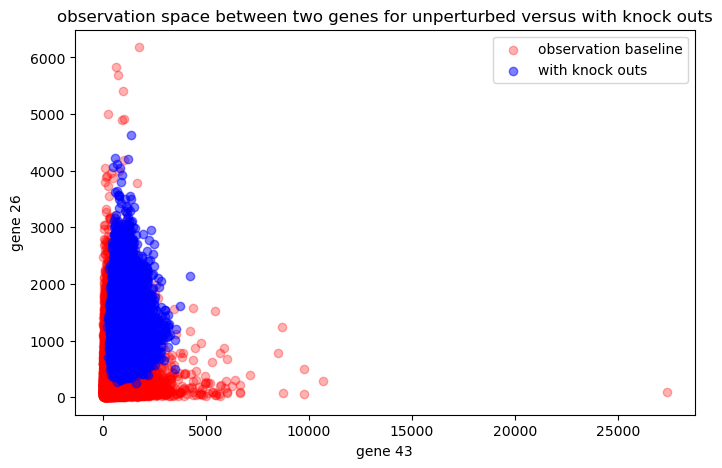

In [170]:
g1 = 43
g2 = 26
plt.figure(figsize=(8,5))
plt.scatter(X[:,g1],X[:,g2], color='red', alpha=0.3, label='observation baseline')
plt.scatter(X_d[:,g1],X_d[:,g2], color='blue', alpha=0.5, label='with knock outs')
plt.xlabel('gene {}'.format(g1))
plt.ylabel('gene {}'.format(g2))
plt.legend()
plt.title('observation space between two genes for unperturbed versus with knock outs')

Define the perturbations.

In [213]:
# assume 20 different perturbations, chosen at random. 
# will be binary array od 1000 values
M_pert = randbin(K,N, p, seed=999)

# need to extend it to 20 000 observations
M_pert.shape

(20, 1000)

Text(0, 0.5, 'Frequency')

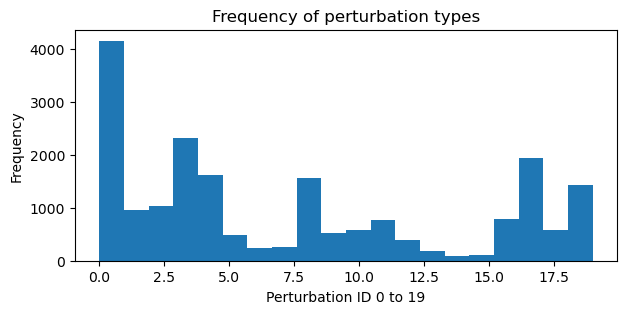

In [208]:
np.random.seed(999)
pert_keys = np.random.choice([i for i in range(20)],20000, p = [0.2, 0.05, 0.05, 0.12, 0.08, 0.025, 0.0125, 0.0125, 0.075, 0.025, 0.03, 0.04, 0.02, 0.01, 0.005, 0.005, 0.04, 0.1, 0.03, 0.07])
plt.figure(figsize=(7,3))
plt.hist(pert_keys,bins=20)
plt.title("Frequency of perturbation types")
plt.xlabel("Perturbation ID 0 to 19")
plt.ylabel('Frequency')

In [217]:
D_pert = np.array([M_pert[pert_keys[i],:] for i in range(20000)]).reshape(20000,1000)

<Axes: >

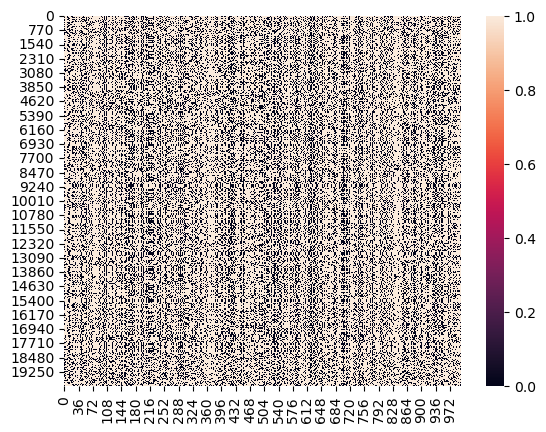

In [220]:
sns.heatmap(D_pert)

In [241]:
pip install --upgrade --quiet jupyter_client ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [244]:
from tqdm import tqdm

In [245]:
X_d = np.empty((20000,1000))
for i in tqdm(range(20000)):
    d = D_pert[i,:]
    X_d[i,:] = poisson_lognormal(np.multiply(B.T,d).T@Z)



  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 24/20000 [00:00<01:23, 239.36it/s]

  2%|▏         | 304/20000 [00:00<00:11, 1741.33it/s]

  2%|▏         | 482/20000 [00:00<00:11, 1758.25it/s]

  3%|▎         | 658/20000 [00:00<00:22, 849.72it/s] 

  4%|▍         | 784/20000 [00:01<00:41, 462.68it/s]

  4%|▍         | 898/20000 [00:01<00:34, 551.35it/s]

  6%|▌         | 1105/20000 [00:01<00:23, 790.70it/s]

  6%|▋         | 1265/20000 [00:01<00:19, 939.35it/s]

  7%|▋         | 1472/20000 [00:01<00:15, 1174.37it/s]

  9%|▊         | 1706/20000 [00:01<00:12, 1441.31it/s]

  9%|▉         | 1891/20000 [00:01<00:11, 1538.80it/s]

 10%|█         | 2075/20000 [00:01<00:11, 1523.29it/s]

 11%|█         | 2249/20000 [00:02<00:11, 1558.40it/s]

 12%|█▏        | 2420/20000 [00:02<00:11, 1569.70it/s]

 13%|█▎        | 2620/20000 [00:02<00:10, 1687.01it/s]

 14%|█▍        | 2824/20000 [00:02<00:09, 1785.57it/s]

 15%|█▌        | 3010/20000 [00:02<00:10, 1574.76it/s]

 16%|█▌        

<Axes: >

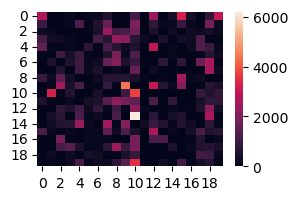

In [256]:
plt.figure(figsize=(3,2))
sns.heatmap(X_d[:20,:20])

#### Transform to AnnData and pass through CPA

In [260]:
import anndata as ad

In [259]:
X_d = sp.sparse.csr_matrix(X_d)

In [261]:
adata = ad.AnnData(X_d)

In [262]:
adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = [f"Gene_{i:d}" for i in range(adata.n_vars)]
print(adata.obs_names[:10])

Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4', 'Cell_5', 'Cell_6',
       'Cell_7', 'Cell_8', 'Cell_9'],
      dtype='object')


In [276]:
adata.obs["perturbation_ID"] = pd.Categorical(['pert_' + str(pert_keys[i]) for i in range(len(pert_keys))])
adata.obs.head()

,perturbation_ID
Cell_0,pert_17
Cell_1,pert_6
Cell_2,pert_0
Cell_3,pert_9
Cell_4,pert_0


In [300]:
adata.obs['dosage_id'] = adata.obs['perturbation_ID'].astype(str).apply(lambda x: '+'.join(['1.0' for _ in x.split('+')])).values
adata.obs.head()

,perturbation_ID,dosage_id
Cell_0,pert_17,1.0
Cell_1,pert_6,1.0
Cell_2,pert_0,1.0
Cell_3,pert_9,1.0
Cell_4,pert_0,1.0


In [301]:
sc.pp.filter_cells(adata, min_counts=100)

NameError: name 'sc' is not defined

#### Try on CPA

In [293]:
!conda install scvi-tools -c conda-forge

In [298]:
import cpa

ModuleNotFoundError: No module named 'scvi'

In [297]:
cpa.CPA.setup_anndata(adata, 
                      perturbation_key='pert_key',
                      control_group='pert_0',
                      dosage_key='dose_value',
                      categorical_covariate_keys=['cell_type'],
                      is_count_data=True,
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_cond',
                      max_comb_len=2,
                     )

NameError: name 'cpa' is not defined

### Poisson-Gamma mixture $Z_i \sim \Gamma(a_i,b_i)$